# Titanic - Predicting Survival
### By Nico Hertel
mail@nicohertel.de

##### Problem Description (from https://www.kaggle.com/c/titanic)
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

##### Evaluation
It is your job to predict if a passenger survived the sinking of the Titanic or not.
For each PassengerId in the test set, you must predict a 0 or 1 value for the Survived variable.

Your score is the percentage of passengers you correctly predict. This is known simply as "accuracy”.

#### Results
The final classifier results in a score of 0.77511, which corresponds to the 5475th place on the kaggle leaderboard for this challenge (Date: 18.05.2018, together with 782 other submissions).

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV

In [3]:
% matplotlib inline

sns.set_style('darkgrid')
sns.set_palette("husl")

### Data Exploration

In [107]:
data = pd.read_csv('titanic_train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We have categorical and numerical data:
    - Categorical: Name, Sex, Ticket, Cabin and Embarked
    - Numerical: ID, Survied, Pclass, Age, SibSP, Parch, Fare

Also, the cabin-information is missing in most (77%) cases

Ticket information is numeric or alphanumeric, Cabin is alphanumeric -> Translate into numeric values?

Embarked is encoding the port of Embarkation, C=Cherbourg, Q=Queenstown, S=Southampton
-> Embarked and Sex can be hot encoded

In [59]:
print('%.2f%% of passangers in the trainign data survived, compared to ~32%% of all passangers' %(100*np.mean(data['Survived'])))
print('%.2f%% of passangers traveled without children/parents' %(100*np.sum(data['Parch']==0)/len(data['Parch'])))
print('%.2f%% of passangers traveled without siblings/spouses' %(100*np.sum(data['SibSp']==0)/len(data['SibSp'])))
print('%.2f%% of passangers were male' %(100*np.sum(data['Sex']=='male')/len(data['Sex'])))

38.38% of passangers in the trainign data survived, compared to ~32% of all passangers
76.09% of passangers traveled without children/parents
68.24% of passangers traveled without siblings/spouses
64.76% of passangers were male


In [40]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [60]:
data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


### Results of Data Exploration

#### Observations
- Age is missing a big amount of data -> Fill gaps
 - Set gap to mean age
 - Predict age
- Many doublicates in ticket (681/891=0.76 unique entries) -> if no correlation with surviaval, drop
- Cabin has very few entries -> maybe drop, but probably correlated to survival (position on the ship)
- PassengerID is not relevant for survival
- Name has no distinct pattern, maybe able to extract more information, else drop

#### Ideas
- Extract Title from Name -> maybe correlated with survival and/or passenger class
- Combine Number of Siblings, Spouses, Parents and Children into one family-parameter

#### Hypotheses
- Females are more likely to survive than male
- Children are more likely to survive than adults (Till what age?)
- Upper-Class passengers are more likely to survive than others

### Check Hypotheses

In [71]:
data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


#### Females are more likely to survive than male
True, 74% of females survived, but only 19% of males

In [72]:
data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


#### Upper-Class passengers are more likely to survive than others
True, 63% of First-Class passengers survived, while only 47% of Second-Class and 24% of Third-Class passengers survived

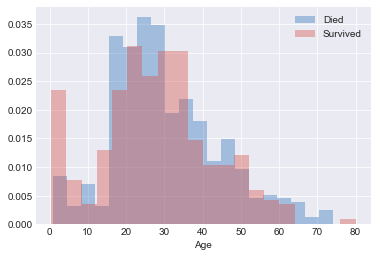

In [89]:
sns.distplot(data[data['Survived'] == 0]['Age'].dropna(), kde=False, label='Died',
             norm_hist=True, bins=20, color=sns.xkcd_rgb["windows blue"])
sns.distplot(data[data['Survived'] == 1]['Age'].dropna(), kde=False, label='Survived',
             norm_hist=True, bins=20, color=sns.xkcd_rgb["pale red"])
plt.legend()
plt.show()

#### Children are more likely to survive than adults (Till what age?)
Seems to be true, especially for babys, but in general till apox 14 years 

### More Data Exploration

#### Check Influence of Embark

In [90]:
data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


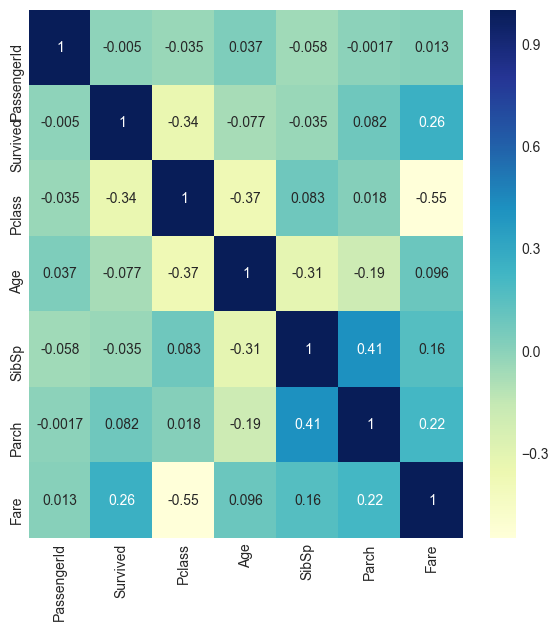

In [5]:
plt.figure(figsize=(7,7), dpi=100)
correlation = data.corr()
sns.heatmap(correlation, cmap='YlGnBu', annot=True)
plt.show()

In [108]:
correlation['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

- Ticket Price and Passenger Class highly correlated with survival
- Age slightly correlated with survival
- PassengerID not correlated with survival

### Modify Data

- Translate categorical into numerical data
- Remove cabin, name PassengerID and ticket information

In [108]:
for key in ['Ticket', 'Name', 'Cabin', 'PassengerId']:
    if key in data.columns:
        data.drop([key], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [109]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


#### Calculate Correlation including categorical data

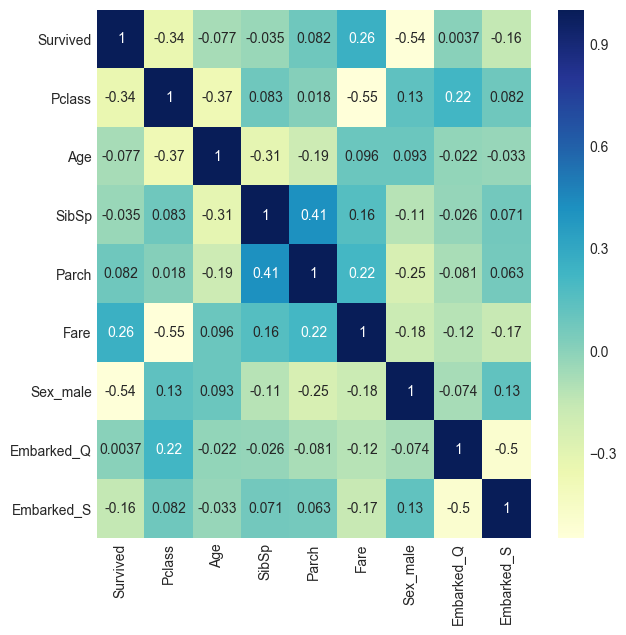

In [9]:
correlation_cat = data.corr()
plt.figure(figsize=(7,7), dpi=100)
sns.heatmap(correlation_cat, cmap='YlGnBu', annot=True)
plt.show()

In [10]:
correlation_cat['Survived']

Survived      1.000000
Pclass       -0.338481
Age          -0.077221
SibSp        -0.035322
Parch         0.081629
Fare          0.257307
Sex_male     -0.543351
Embarked_Q    0.003650
Embarked_S   -0.155660
Name: Survived, dtype: float64

### Estimating missing age values
Age is slightly gaussian distributed:
$$\mu_{age}=29.7$$, $$\sigma_{age}=14.5$$
Idea: Using subsets of age with corresponding class and sex values to generate random values for missing age-values, so:
$$Age(sex=male, class=1) \sim \mathcal{N}(\mu_{male,1}, \sigma_{male,1})$$
with $$\mu_{sex, class}$$ and $$\sigma_{sex, class}$$ describing the mean and standard deviation of age for this sex and class

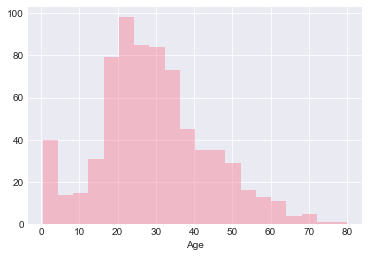

In [148]:
sns.distplot(data_clean['Age'].dropna(), kde=False)
plt.show()

In [90]:
male_c1 = data[(data['Sex_male']==1) & (data['Pclass']==1)]['Age']
male_c2 = data[(data['Sex_male']==1) & (data['Pclass']==2)]['Age']
male_c3 = data[(data['Sex_male']==1) & (data['Pclass']==3)]['Age']
female_c1 = data[(data['Sex_male']==0) & (data['Pclass']==1)]['Age']
female_c2 = data[(data['Sex_male']==0) & (data['Pclass']==2)]['Age']
female_c3 = data[(data['Sex_male']==0) & (data['Pclass']==3)]['Age']

mean_male_c1 = np.mean(male_c1.dropna())
std_male_c1 = np.std(male_c1.dropna())
mean_male_c2 = np.mean(male_c2.dropna())
std_male_c2 = np.std(male_c2.dropna())
mean_male_c3 = np.mean(male_c3.dropna())
std_male_c3 = np.std(male_c3.dropna())

mean_female_c1 = np.mean(female_c1.dropna())
std_female_c1 = np.std(female_c1.dropna())
mean_female_c2 = np.mean(female_c2.dropna())
std_female_c2 = np.std(female_c2.dropna())
mean_female_c3 = np.mean(female_c3.dropna())
std_female_c3 = np.std(female_c3.dropna())

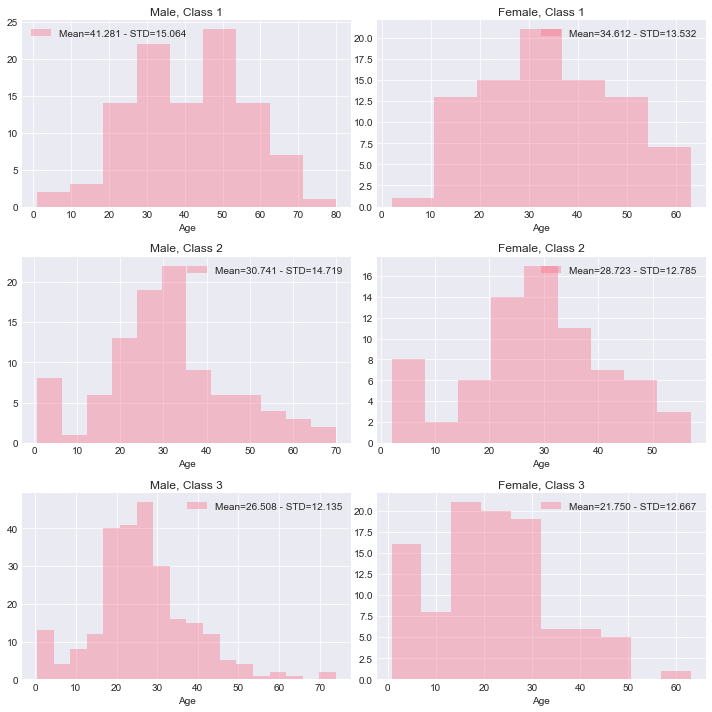

In [91]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
sns.distplot(male_c1.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_male_c1, std_male_c1), kde=False, ax=ax[0][0])
ax[0][0].legend()
ax[0][0].set_title('Male, Class 1')
sns.distplot(male_c2.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_male_c2, std_male_c2), kde=False, ax=ax[1][0])
ax[1][0].legend()
ax[1][0].set_title('Male, Class 2')
sns.distplot(male_c3.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_male_c3, std_male_c3), kde=False, ax=ax[2][0])
ax[2][0].legend()
ax[2][0].set_title('Male, Class 3')
sns.distplot(female_c1.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_female_c1, std_female_c1), kde=False, ax=ax[0][1])
ax[0][1].legend()
ax[0][1].set_title('Female, Class 1')
sns.distplot(female_c2.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_female_c2, std_female_c2), kde=False, ax=ax[1][1])
ax[1][1].legend()
ax[1][1].set_title('Female, Class 2')
sns.distplot(female_c3.dropna(), label='Mean=%.3f - STD=%.3f' %(mean_female_c3, std_female_c3), kde=False, ax=ax[2][1])
ax[2][1].legend()
ax[2][1].set_title('Female, Class 3')


plt.tight_layout()
plt.show()

In [152]:
def replace_age(data, sex, Pclass, mean, std, sex_key='Sex'):
    '''
    Replaces all nan-values for age in data with corresponding sex and Pclass with random values,
    taken from a gaussian distribution with parameters mean and std

    Parameters
    ----------
    data : DataFrame
    sex : string ('male' or 'female')
    Pclass : int (1, 2 or 3)
    mean : float
    std : float

    Output
    ------
    data : DataFrame
    '''
    
    subset = data[(data[sex_key]==sex) & (data['Pclass']==Pclass)]
    idx = subset[subset['Age'].isnull()].index
    n_missing = len(subset[subset['Age'].isnull()])
    rand = np.random.normal(loc=mean, scale=std, size=[n_missing, ])
    print('%i missing values detected' %n_missing)
    for i, ind in enumerate(idx):
        data.loc[ind, 'Age'] = int(rand[i])
        subset.loc[ind, 'Age'] = int(rand[i])
    print('%i missing values remaining' %len(subset[subset['Age'].isnull()]))
    return data

In [110]:
data = replace_age(data, sex=1, Pclass=1, mean=mean_male_c1, std=std_male_c1)
data = replace_age(data, sex=1, Pclass=2, mean=mean_male_c2, std=std_male_c2)
data = replace_age(data, sex=1, Pclass=3, mean=mean_male_c3, std=std_male_c3)
data = replace_age(data, sex=0, Pclass=1, mean=mean_female_c1, std=std_female_c1)
data = replace_age(data, sex=0, Pclass=2, mean=mean_female_c2, std=std_female_c2)
data = replace_age(data, sex=0, Pclass=3, mean=mean_female_c3, std=std_female_c3)


21 missing values detected


C:\Users\mail\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0 missing values remaining
9 missing values detected
0 missing values remaining
94 missing values detected
0 missing values remaining
9 missing values detected
0 missing values remaining
2 missing values detected
0 missing values remaining
42 missing values detected
0 missing values remaining


In [115]:
correlation = data.corr()
print(correlation['Survived'])

Survived      1.000000
Pclass       -0.338481
Age          -0.052639
SibSp        -0.035322
Parch         0.081629
Fare          0.257307
Sex_male     -0.543351
Embarked_Q    0.003650
Embarked_S   -0.155660
Name: Survived, dtype: float64


Age has still very low correlation with survival, maybe create agegroups instead, but how many?
Let's try 3 different sets: 3 groups, 5 groups and 8 groups and look at their correlation

In [121]:
data['3 Age Groups'] = pd.cut(data['Age'], 3)
data['5 Age Groups'] = pd.cut(data['Age'], 5)
data['8 Age Groups'] = pd.cut(data['Age'], 8)

data[['3 Age Groups', 'Survived']].groupby(['3 Age Groups'], as_index=False).mean()

,3 Age Groups,Survived
0,"(-4.084, 24.0]",0.395415
1,"(24.0, 52.0]",0.380165
2,"(52.0, 80.0]",0.344828


In [122]:
data[['5 Age Groups', 'Survived']].groupby(['5 Age Groups'], as_index=False).mean()

,5 Age Groups,Survived
0,"(-4.084, 12.8]",0.528090
1,"(12.8, 29.6]",0.351010
2,"(29.6, 46.4]",0.385666
3,"(46.4, 63.2]",0.414141
4,"(63.2, 80.0]",0.142857


In [123]:
data[['8 Age Groups', 'Survived']].groupby(['8 Age Groups'], as_index=False).mean()

,8 Age Groups,Survived
0,"(-4.084, 6.5]",0.596774
1,"(6.5, 17.0]",0.373626
2,"(17.0, 27.5]",0.360000
3,"(27.5, 38.0]",0.386179
4,"(38.0, 48.5]",0.338710
5,"(48.5, 59.0]",0.406250
6,"(59.0, 69.5]",0.333333
7,"(69.5, 80.0]",0.250000


8 Age groups show good correlations with survival, but all have higher correlation than the rare age-value!
- Replace Age by Age-Group
- Try similar grouping for fare


In [127]:
for key in ['3 Age Groups', '5 Age Groups', 'Age']:
    if key in data.columns:
        data.drop([key], axis=1, inplace=True)
data = pd.get_dummies(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
Survived                      891 non-null int64
Pclass                        891 non-null int64
SibSp                         891 non-null int64
Parch                         891 non-null int64
Fare                          891 non-null float64
Sex_male                      891 non-null uint8
Embarked_Q                    891 non-null uint8
Embarked_S                    891 non-null uint8
8 Age Groups_(-4.084, 6.5]    891 non-null uint8
8 Age Groups_(6.5, 17.0]      891 non-null uint8
8 Age Groups_(17.0, 27.5]     891 non-null uint8
8 Age Groups_(27.5, 38.0]     891 non-null uint8
8 Age Groups_(38.0, 48.5]     891 non-null uint8
8 Age Groups_(48.5, 59.0]     891 non-null uint8
8 Age Groups_(59.0, 69.5]     891 non-null uint8
8 Age Groups_(69.5, 80.0]     891 non-null uint8
dtypes: float64(1), int64(4), uint8(11)
memory usage: 44.5 KB


In [128]:
data['3 Fare Groups'] = pd.cut(data['Fare'], 3)
data['5 Fare Groups'] = pd.cut(data['Fare'], 5)
data['8 Fare Groups'] = pd.cut(data['Fare'], 8)

data[['3 Fare Groups', 'Survived']].groupby(['3 Fare Groups'], as_index=False).mean()

,3 Fare Groups,Survived
0,"(-0.512, 170.776]",0.376579
1,"(170.776, 341.553]",0.647059
2,"(341.553, 512.329]",1.000000


In [129]:
data[['5 Fare Groups', 'Survived']].groupby(['5 Fare Groups'], as_index=False).mean()

,5 Fare Groups,Survived
0,"(-0.512, 102.466]",0.361575
1,"(102.466, 204.932]",0.757576
2,"(204.932, 307.398]",0.647059
3,"(307.398, 409.863]",NaN
4,"(409.863, 512.329]",1.000000


In [130]:
data[['8 Fare Groups', 'Survived']].groupby(['8 Fare Groups'], as_index=False).mean()

,8 Fare Groups,Survived
0,"(-0.512, 64.041]",0.337646
1,"(64.041, 128.082]",0.662500
2,"(128.082, 192.123]",0.777778
3,"(192.123, 256.165]",0.636364
4,"(256.165, 320.206]",0.666667
5,"(320.206, 384.247]",NaN
6,"(384.247, 448.288]",NaN
7,"(448.288, 512.329]",1.000000


There seems to be a too big gap between the lower fares (300 and lower) and the higher ones (No entries for the NaN-categories). Therefore, divide Fare into three groups with good correlation

In [133]:
for key in ['5 Fare Groups', '8 Fare Groups', 'Fare']:
    if key in data.columns:
        data.drop([key], axis=1, inplace=True)
data = pd.get_dummies(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
Survived                            891 non-null int64
Pclass                              891 non-null int64
SibSp                               891 non-null int64
Parch                               891 non-null int64
Sex_male                            891 non-null uint8
Embarked_Q                          891 non-null uint8
Embarked_S                          891 non-null uint8
8 Age Groups_(-4.084, 6.5]          891 non-null uint8
8 Age Groups_(6.5, 17.0]            891 non-null uint8
8 Age Groups_(17.0, 27.5]           891 non-null uint8
8 Age Groups_(27.5, 38.0]           891 non-null uint8
8 Age Groups_(38.0, 48.5]           891 non-null uint8
8 Age Groups_(48.5, 59.0]           891 non-null uint8
8 Age Groups_(59.0, 69.5]           891 non-null uint8
8 Age Groups_(69.5, 80.0]           891 non-null uint8
3 Fare Groups_(-0.512, 170.776]     891 non-null uint8
3 Fare Groups_(

In [134]:
correlation = data.corr()
print(correlation['Survived'])

Survived                            1.000000
Pclass                             -0.338481
SibSp                              -0.035322
Parch                               0.081629
Sex_male                           -0.543351
Embarked_Q                          0.003650
Embarked_S                         -0.155660
8 Age Groups_(-4.084, 6.5]          0.119742
8 Age Groups_(6.5, 17.0]           -0.007082
8 Age Groups_(17.0, 27.5]          -0.032752
8 Age Groups_(27.5, 38.0]           0.002972
8 Age Groups_(38.0, 48.5]          -0.037312
8 Age Groups_(48.5, 59.0]           0.012820
8 Age Groups_(59.0, 69.5]          -0.016135
8 Age Groups_(69.5, 80.0]          -0.026195
3 Fare Groups_(-0.512, 170.776]    -0.098513
3 Fare Groups_(170.776, 341.553]    0.075486
3 Fare Groups_(341.553, 512.329]    0.073642
Name: Survived, dtype: float64


### Fazit
- Removed the following parameters:
    - Ticket
    - Name
    - Cabin
    - PassengerId
- Filled the missing Age-Values by drawing from a normal distribution with parameters corresponding to the Pclass/Sex-filtered distribution of the given Age-Values
- Filled missing Embarked-Values with most common value (S)
- Divided Age into eight groups
- Divided Fare into three groups
- Created numerical parameters for Embarked and Sex

Possible Problem: 17 categories, eight of them for age, three for fare might be problematic. Convert them into only one category for each parameter (same for embarked)

#### Complete Data Preparation

In [149]:
data = pd.read_csv('titanic_train.csv')

In [153]:
# Fill missing age parameter
male_c1 = data[(data['Sex']=='male') & (data['Pclass']==1)]['Age']
male_c2 = data[(data['Sex']=='male') & (data['Pclass']==2)]['Age']
male_c3 = data[(data['Sex']=='male') & (data['Pclass']==3)]['Age']
female_c1 = data[(data['Sex']=='female') & (data['Pclass']==1)]['Age']
female_c2 = data[(data['Sex']=='female') & (data['Pclass']==2)]['Age']
female_c3 = data[(data['Sex']=='female') & (data['Pclass']==3)]['Age']

mean_male_c1 = np.mean(male_c1.dropna())
std_male_c1 = np.std(male_c1.dropna())
mean_male_c2 = np.mean(male_c2.dropna())
std_male_c2 = np.std(male_c2.dropna())
mean_male_c3 = np.mean(male_c3.dropna())
std_male_c3 = np.std(male_c3.dropna())

mean_female_c1 = np.mean(female_c1.dropna())
std_female_c1 = np.std(female_c1.dropna())
mean_female_c2 = np.mean(female_c2.dropna())
std_female_c2 = np.std(female_c2.dropna())
mean_female_c3 = np.mean(female_c3.dropna())
std_female_c3 = np.std(female_c3.dropna())

data = replace_age(data, sex='male', Pclass=1, mean=mean_male_c1, std=std_male_c1)
data = replace_age(data, sex='male', Pclass=2, mean=mean_male_c2, std=std_male_c2)
data = replace_age(data, sex='male', Pclass=3, mean=mean_male_c3, std=std_male_c3)
data = replace_age(data, sex='female', Pclass=1, mean=mean_female_c1, std=std_female_c1)
data = replace_age(data, sex='female', Pclass=2, mean=mean_female_c2, std=std_female_c2)
data = replace_age(data, sex='female', Pclass=3, mean=mean_female_c3, std=std_female_c3)

21 missing values detected


C:\Users\mail\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0 missing values remaining
9 missing values detected
0 missing values remaining
94 missing values detected
0 missing values remaining
9 missing values detected
0 missing values remaining
2 missing values detected
0 missing values remaining
42 missing values detected
0 missing values remaining


In [171]:
# Fill Embarked with most common value
data['Embarked'] = data['Embarked'].fillna('S')

In [172]:
# Create numeric value for Embarked, Sex, Age and Fare
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
data['Sex'] = data['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
data.loc[ data['Age'] <=6.5, 'Age'] = 0
data.loc[(data['Age'] > 6.5) & (data['Age'] <= 17), 'Age'] = 1
data.loc[(data['Age'] > 17) & (data['Age'] <= 27.5), 'Age'] = 2
data.loc[(data['Age'] > 27.5) & (data['Age'] <= 38), 'Age'] = 3
data.loc[(data['Age'] > 38) & (data['Age'] <= 48.5), 'Age'] = 4
data.loc[(data['Age'] > 48.5) & (data['Age'] <= 59), 'Age'] = 5
data.loc[(data['Age'] > 59) & (data['Age'] <= 69.5), 'Age'] = 6
data.loc[ data['Age'] > 69.5, 'Age'] = 7
data.loc[ data['Fare'] <= 170, 'Fare'] = 0
data.loc[(data['Fare'] > 170) & (data['Fare'] <= 341), 'Fare'] = 1
data.loc[ data['Fare'] > 341, 'Fare'] = 2

In [178]:
for key in ['Ticket', 'Name', 'Cabin', 'PassengerId']:
    if key in data.columns:
        data.drop([key], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int32
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null int32
dtypes: float64(2), int32(2), int64(4)
memory usage: 48.8 KB


In [179]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,2.0,1,0,0.0,0
1,1,1,1,3.0,1,0,0.0,1
2,1,3,1,2.0,0,0,0.0,0
3,1,1,1,3.0,1,0,0.0,0
4,0,3,0,3.0,0,0,0.0,0


In [188]:
data.to_csv('18-05-2018_titanic_train_edited.csv')

## Moddeling and Predicting
This is a standard classification problem, so multiple algorithms might apply, for example:
- Logistic Regression
- Support Vector Machines
- k-Nearest-Neighbors
- Random Tree/Forest

For Neural Networks, the given training data is way too small. 17 categories might be too high dimensional for kNN, but still worth a try. For now I will compare Logistic Regression kNN and SVM and maybe include Random Forests later

In [213]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

#### Prepare Data for Modelling

In [183]:
X_keys = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
           'Embarked']
y_key = 'Survived'

In [186]:
X = data[X_keys]
y = data[y_key]

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print('Shape X_train: ' + str(X_train.shape) + ' - Shape X_test: ' + str(X_test.shape))
print('Shape y_train: ' + str(y_train.shape) + ' - Shape y_test: ' + str(y_test.shape))

Shape X_train: (596, 7) - Shape X_test: (295, 7)
Shape y_train: (596,) - Shape y_test: (295,)


#### Logistic Regression

In [214]:
logreg = LogisticRegressionCV()
parameters = {'Cs': [1, 5, 10, 15, 20, 50], 'solver' : ['liblinear', 'lbfgs'], 'class_weight' : ['balanced']}
clf = GridSearchCV(logreg, parameters, scoring='accuracy')
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'Cs': 50, 'class_weight': 'balanced', 'solver': 'liblinear'}

Grid scores:

0.768 (+/-0.037) for {'Cs': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}
0.789 (+/-0.016) for {'Cs': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.789 (+/-0.035) for {'Cs': 5, 'class_weight': 'balanced', 'solver': 'liblinear'}
0.787 (+/-0.033) for {'Cs': 5, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.789 (+/-0.035) for {'Cs': 10, 'class_weight': 'balanced', 'solver': 'liblinear'}
0.785 (+/-0.037) for {'Cs': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.789 (+/-0.035) for {'Cs': 15, 'class_weight': 'balanced', 'solver': 'liblinear'}
0.787 (+/-0.040) for {'Cs': 15, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.789 (+/-0.035) for {'Cs': 20, 'class_weight': 'balanced', 'solver': 'liblinear'}
0.787 (+/-0.040) for {'Cs': 20, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.790 (+/-0.031) for {'Cs': 50, 'class_weight': 'balanced', 'solver': 

In [215]:
logreg = LogisticRegressionCV()
best_params = {'Cs': 50, 'class_weight': 'balanced', 'solver': 'liblinear'}
logreg.set_params(**best_params)
logreg.fit(X_train, y_train)
print(classification_report(y_test, logreg.predict(X_test)))
logreg_acc = accuracy_score(y_test, logreg.predict(X_test))
print('\nAccuracy: %.3f' % logreg_acc)

             precision    recall  f1-score   support

          0       0.82      0.80      0.81       177
          1       0.71      0.73      0.72       118

avg / total       0.77      0.77      0.77       295


Accuracy: 0.773


In [216]:
logreg_coeff = pd.DataFrame(data.columns.delete(0))
logreg_coeff.columns = ['Feature']
logreg_coeff["Correlation"] = pd.Series(logreg.coef_[0])
logreg_coeff.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,1.309604
6,Embarked,0.279340
5,Fare,0.028693
4,Parch,-0.061776
3,SibSp,-0.328601
2,Age,-0.632816
0,Pclass,-1.030131


#### k Nearest Neighbors

In [225]:
kNN = KNeighborsClassifier()
parameters = {'n_neighbors' : [3, 5, 10, 15, 20, 50], 'weights': ['uniform', 'distance']}
clf = GridSearchCV(kNN, parameters, scoring='accuracy')
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'n_neighbors': 10, 'weights': 'uniform'}

Grid scores:

0.770 (+/-0.063) for {'n_neighbors': 3, 'weights': 'uniform'}
0.765 (+/-0.058) for {'n_neighbors': 3, 'weights': 'distance'}
0.805 (+/-0.030) for {'n_neighbors': 5, 'weights': 'uniform'}
0.790 (+/-0.005) for {'n_neighbors': 5, 'weights': 'distance'}
0.824 (+/-0.023) for {'n_neighbors': 10, 'weights': 'uniform'}
0.800 (+/-0.005) for {'n_neighbors': 10, 'weights': 'distance'}
0.814 (+/-0.031) for {'n_neighbors': 15, 'weights': 'uniform'}
0.800 (+/-0.039) for {'n_neighbors': 15, 'weights': 'distance'}
0.815 (+/-0.030) for {'n_neighbors': 20, 'weights': 'uniform'}
0.799 (+/-0.029) for {'n_neighbors': 20, 'weights': 'distance'}
0.804 (+/-0.025) for {'n_neighbors': 50, 'weights': 'uniform'}
0.799 (+/-0.017) for {'n_neighbors': 50, 'weights': 'distance'}


In [223]:
kNN = KNeighborsClassifier()
best_params = {'n_neighbors': 10, 'weights': 'uniform'}
kNN.set_params(**best_params)
kNN.fit(X_train, y_train)
print(classification_report(y_test, kNN.predict(X_test)))
kNN_acc = accuracy_score(y_test, kNN.predict(X_test))
print('\nAccuracy: %.3f' % kNN_acc)

             precision    recall  f1-score   support

          0       0.77      0.90      0.83       177
          1       0.81      0.60      0.69       118

avg / total       0.79      0.78      0.78       295


Accuracy: 0.783


#### Support Vector Machine
(May take some time)

In [219]:
SVM = SVC()
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
               'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
clf = GridSearchCV(SVM, parameters, scoring='accuracy')
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores:

0.638 (+/-0.002) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.624 (+/-0.003) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.799 (+/-0.021) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.638 (+/-0.002) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.797 (+/-0.016) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.799 (+/-0.021) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.812 (+/-0.024) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.797 (+/-0.016) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.795 (+/-0.012) for {'C': 1, 'kernel': 'linear'}
0.799 (+/-0.021) for {'C': 10, 'kernel': 'linear'}
0.800 (+/-0.026) for {'C': 100, 'kernel': 'linear'}
0.799 (+/-0.021) for {'C': 1000, 'kernel': 'linear'}


In [220]:
SVM = SVC()
best_params = {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVM.set_params(**best_params)
SVM.fit(X_train, y_train)
print(classification_report(y_test, SVM.predict(X_test)))
SVM_acc = accuracy_score(y_test, SVM.predict(X_test))
print('\nAccuracy: %.3f' % SVM_acc)

             precision    recall  f1-score   support

          0       0.79      0.88      0.83       177
          1       0.78      0.66      0.72       118

avg / total       0.79      0.79      0.79       295


Accuracy: 0.790


## Classification Results

- Logistic Regression: ACC = 0.773
- k Nearest Neighbours: ACC = 0.783
- Support Vector Machine : ACC = 0.790

Best Parameters for SVM: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

# Predicting Test Dataset for Competition

### First, prepare Data like before

In [227]:
test_data = pd.read_csv('titanic_test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [228]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [229]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [230]:
test_data = replace_age(test_data, sex='male', Pclass=1, mean=mean_male_c1, std=std_male_c1)
test_data = replace_age(test_data, sex='male', Pclass=2, mean=mean_male_c2, std=std_male_c2)
test_data = replace_age(test_data, sex='male', Pclass=3, mean=mean_male_c3, std=std_male_c3)
test_data = replace_age(test_data, sex='female', Pclass=1, mean=mean_female_c1, std=std_female_c1)
test_data = replace_age(test_data, sex='female', Pclass=2, mean=mean_female_c2, std=std_female_c2)
test_data = replace_age(test_data, sex='female', Pclass=3, mean=mean_female_c3, std=std_female_c3)

7 missing values detected


C:\Users\mail\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0 missing values remaining
4 missing values detected
0 missing values remaining
50 missing values detected
0 missing values remaining
2 missing values detected
0 missing values remaining
1 missing values detected
0 missing values remaining
22 missing values detected
0 missing values remaining


In [248]:
# One missing Fare-Value, replace with most common for same Pclass (3, which is 0 
test_data.loc[152, 'Fare'] = 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [249]:
# Create numeric value for Embarked, Sex, Age and Fare
test_data['Embarked'] = test_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test_data['Sex'] = test_data['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
test_data.loc[ test_data['Age'] <=6.5, 'Age'] = 0
test_data.loc[(test_data['Age'] > 6.5) & (test_data['Age'] <= 17), 'Age'] = 1
test_data.loc[(test_data['Age'] > 17) & (test_data['Age'] <= 27.5), 'Age'] = 2
test_data.loc[(test_data['Age'] > 27.5) & (test_data['Age'] <= 38), 'Age'] = 3
test_data.loc[(test_data['Age'] > 38) & (test_data['Age'] <= 48.5), 'Age'] = 4
test_data.loc[(test_data['Age'] > 48.5) & (test_data['Age'] <= 59), 'Age'] = 5
test_data.loc[(test_data['Age'] > 59) & (test_data['Age'] <= 69.5), 'Age'] = 6
test_data.loc[ test_data['Age'] > 69.5, 'Age'] = 7
test_data.loc[ test_data['Fare'] <= 170, 'Fare'] = 0
test_data.loc[(test_data['Fare'] > 170) & (test_data['Fare'] <= 341), 'Fare'] = 1
test_data.loc[ test_data['Fare'] > 341, 'Fare'] = 2

In [251]:
for key in ['Ticket', 'Name', 'Cabin', 'PassengerId']:
    if key in test_data.columns:
        test_data.drop([key], axis=1, inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null int32
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Embarked    418 non-null int32
dtypes: float64(2), int32(2), int64(3)
memory usage: 19.7 KB


### Predict Survival-Label using the SVM-model

In [254]:
X = test_data[X_keys]
X = scaler.transform(X)
y_pred = SVM.predict(X)

In [265]:
submission_data = pd.read_csv('titanic_submission_template.csv')
submission_data.set_index('PassengerId', inplace=True)
submission_data.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [266]:
submission_data['Survived'] = y_pred
submission_data.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [268]:
submission_data.to_csv('18-05-2018_titanic_submission.csv')